In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
image_size = 300
batch_size = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    seed = 123,
    shuffle = True,
    batch_size = batch_size,
    image_size=(image_size,image_size),
)

Found 2528 files belonging to 3 classes.


In [4]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
class_names=dataset.class_names

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch)

(32, 300, 300, 3)
tf.Tensor([0 0 2 2 2 1 0 2 1 0 2 2 2 0 2 2 2 2 0 2 0 1 2 2 2 1 2 2 2 2 0 2], shape=(32,), dtype=int32)


In [7]:
len(dataset)

79

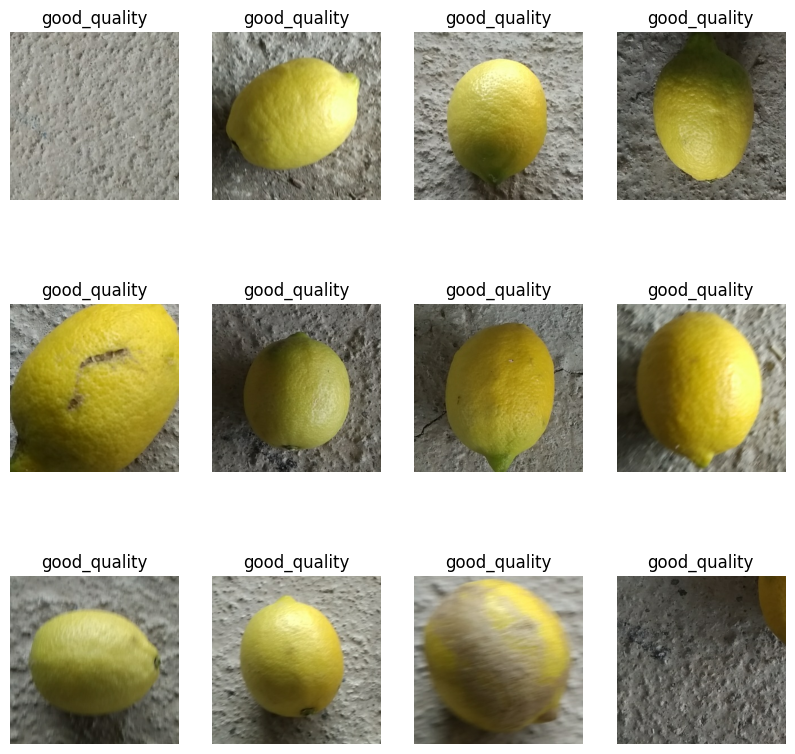

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[1]])
        plt.axis("off")

split the dataset into train test validation

In [9]:
len(dataset)

79

In [10]:
def split_dataset(dataset, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, test_ds, val_ds


In [11]:
train_ds ,val_ds ,test_ds = split_dataset(dataset)

 cache, shuffle, prefetch the dataset

In [12]:
train_ds = train_ds.cache().shuffle (1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle (1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

model building

In [13]:
resize_and_rescale = tf.keras.Sequential([ 
    layers.Resizing(image_size, image_size), 
    layers.Rescaling (1./299),

])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

apply data augmentation in train_ds

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

model architecture

In [16]:
channel=3
n_classes=3

In [17]:
 from tensorflow.keras import models, layers

input_shape = (batch_size, image_size, image_size, channel)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [18]:
model.build(input_shape = input_shape)

In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 300, 300, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 298, 298, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 149, 149, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 147, 147, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 73, 73, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 71, 71, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 35, 35, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 33, 33, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 16, 16, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 14, 14, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 7, 7, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 5, 5, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#compile our model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)    

In [21]:
history = model.fit(
    train_ds,
    batch_size = batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs= 10
)    

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 339s 5s/step - accuracy: 0.5789 - loss: 0.8078 - val_accuracy: 0.8403 - val_loss: 0.3110
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 651s 10s/step - accuracy: 0.8780 - loss: 0.2886 - val_accuracy: 0.9410 - val_loss: 0.1375
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9424 - loss: 0.1294 - val_accuracy: 0.9514 - val_loss: 0.1165
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9287 - loss: 0.1910 - val_accuracy: 0.9479 - val_loss: 0.1331
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9431 - loss: 0.1545 - val_accuracy: 0.9479 - val_loss: 0.1130
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9677 - loss: 0.0885 - val_accuracy: 0.9757 - val_loss: 0.0598
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9737 - loss: 0.0786 - val_accuracy: 0.9653 - val_loss: 0.0739
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9826 - loss: 0.0483 - val_accuracy: 0.9965 - 

In [22]:
scores = model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 74s 667ms/step - accuracy: 0.9941 - loss: 0.0157


In [23]:
scores

[0.022302405908703804, 0.9910714030265808]

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 63}

In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [28]:
epochs = 10

In [30]:
import matplotlib.pyplot as plt

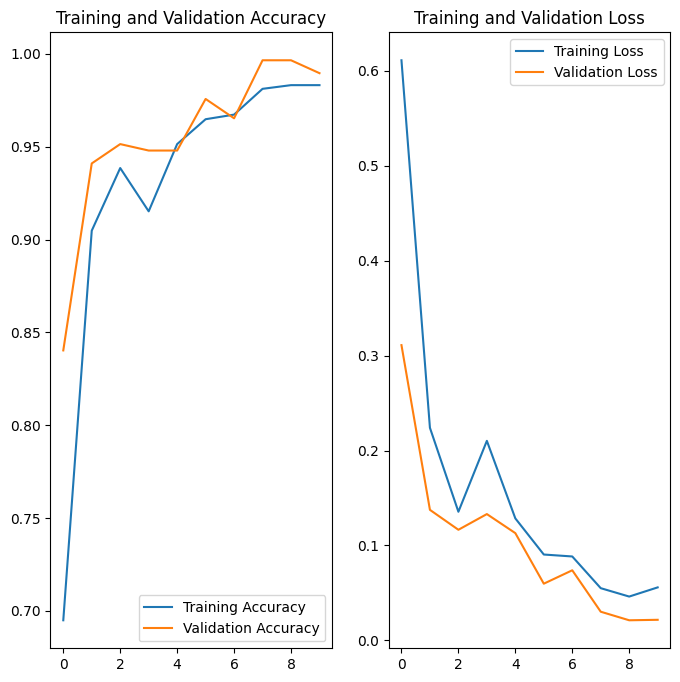

In [32]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)

plt.plot(range(epochs), acc, label='Training Accuracy')

plt.plot(range(epochs), val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')

plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(range(epochs), loss, label='Training Loss')

plt.plot(range(epochs), val_loss, label='Validation Loss')

plt.legend(loc='upper right')

plt.title('Training and Validation Loss')

plt.show()

In [33]:
import numpy as np

first image to predict
actual label good_quality
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted label good_quality


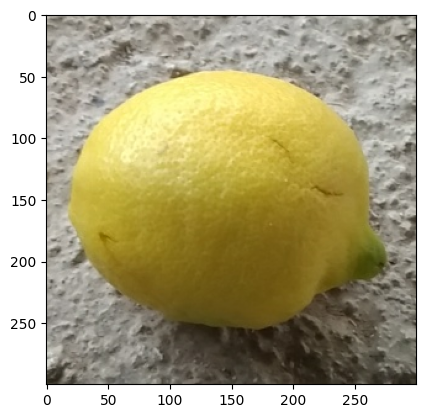

In [34]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label", class_names[np.argmax(batch_prediction[0])])

In [35]:
model.save("model.h5")